# Bird Strikes in Aviation - Aircraft Collisions

### Bonnie Tran

# Import libraries

In [743]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from feature_engine.encoding import CountFrequencyEncoder, RareLabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, roc_curve, auc, roc_auc_score, 
                             classification_report, confusion_matrix)

import random
import tensorflow as tf
import keras

# THE RAW DATA

# Information about dataset

**Link to dataset:** https://www.kaggle.com/datasets/iamtapendu/bird-strike-by-aircafts-data

The data has 25,429 observations and 26 columns. The last column, **`IsAircraftLarge?`** is a binary label for `Yes/No`.


**Description taken from Kaggle**: 

Transport and communication are vital domains within the field of analytics, particularly in addressing safety and environmental concerns linked to the rapid growth of urban areas and increasing air traffic. Among the many risks aviation faces, bird strikes—collisions between aircraft and birds or other wildlife—pose a significant threat. These strikes can cause serious damage to aircraft, particularly jet engines, and have been responsible for some fatal accidents. Bird strikes are most likely to occur during critical flight phases such as take-off, climb, approach, and landing, when aircraft are at lower altitudes and bird activity is higher.

The dataset provided by the FAA, covering incidents from 2000 to 2011. This dataset offers valuable insights into bird strike patterns, focusing on factors such as aircraft type, location, flight phase, and the specific species involved. By analyzing these variables, it helps identify risk factors and trends, supporting the development of strategies to reduce the frequency and impact of bird strikes, ultimately enhancing aviation safety and risk mitigation.

**Hypothesis**: 

Do any of the following features or circumstances pertaining to bird and aircraft collisions have a strong correlation to whether the aircraft hit is large or small?

**Features detailed from Kaggle**:

(1) **`RecordID`**: Record ID o index of each bird strike occurrence (e.g., 25, 429 unique IDs total). 

(2) **`AircraftType`**: The type of aircraft involved in the bird strike incident (e.g., "Airplane").

(3) **`AirportName`**: The name of the airport where the bird strike occurred (e.g., "LAGUARDIA NY", "DALLAS/FORT WORTH INTL ARPT").

(4) **`AltitudeBin`**: The altitude range (in feet) at which the bird strike occurred, divided into bins (e.g., "(1000, 2000]", "(30, 50]").

(5) **`MakeModel`**: The specific make and model of the aircraft involved (e.g., "B-737-400", "MD-80", "A-300").

(6) **`NumberStruck`**: The number of birds that were struck during the incident (e.g., "Over 100", "1", "26").

(7) **`NumberStruckActual`**: The actual number of birds that were struck during the incident (e.g., 859, 424, 261).

(8) **`Effect`**: The effect of the bird strike on the aircraft, indicating whether it caused any damage or not (e.g., "Engine Shut Down", "No damage", "Caused damage").

(9) **`FlightDate`**: The date of the bird strike incident (e.g., "11/23/00 0:00").

(10) **`Damage`**: A description of the damage caused by the bird strike (e.g., "Caused damage", "No damage").

(11) **`Engines`**: The number of engines on the aircraft involved in the bird strike (e.g., 2 engines).

(12) **`Operator`**: The airline or operator of the aircraft involved in the bird strike (e.g., "US AIRWAYS", "AMERICAN AIRLINES", "ALASKA AIRLINES").

(13) **`OriginState`**: The U.S. state where the aircraft originated (e.g., "New York", "Texas", "Washington").

(14) **`FlightPhase`**: The phase of flight during which the bird strike occurred (e.g., "Climb", "Landing Roll", "Approach", "Take-off run")

(15) **`ConditionsPrecipitation`**: The weather condition related to precipitation at the time of the bird strike (e.g., "None", "Some Cloud").

(16) **`RemainsCollected?`**: Indicates whether bird remains were collected after the strike (e.g., "True" or "False").

(17) **`RemainsSentToSmithsonian`**: Indicates whether the bird remains were sent to the Smithsonian Institution for study (e.g., "True" or "False").

(18) **`Remarks`**: Additional comments or notes related to the incident, including specific details like the number of birds involved, actions taken, or other observations (e.g., "FLYING UNDER A VERY LARGE FLOCK OF BIRDS", "BIRD REMAINS ON F/O WINDSCREEN").

(19) **`WildlifeSize`**: The size of the bird or wildlife involved in the strike (e.g., "Small", "Medium").

(20) **`ConditionsSky`**: The sky condition at the time of the bird strike (e.g., "No Cloud", "Some Cloud").

(21) **`WildlifeSpecies`**: The species of the bird or wildlife involved in the strike (e.g., "European starling", "Rock pigeon", "Unknown bird - medium").

(22) **`PilotWarned`**: Indicates whether the pilot was warned about the potential for a bird strike (e.g., "Y" for Yes, "N" for No).

(23) **`Cost`**: The cost incurred as a result of the bird strike (e.g., financial cost to repair damage or related expenses, usually in monetary value like 30,736).

(24) **`Altitude`**: The specific altitude at which the bird strike occurred, typically in feet (e.g., 1500 feet, 50 feet).

(25) **`PeopleInjured`**: The number of people injured as a result of the bird strike (e.g., "0", "50").

**Binary target**:

(26) **`IsAircraftLarge?`**: A binary variable indicating whether the aircraft involved is classified as "large" (e.g., "Yes", "No").

# Load dataset

In [744]:
bird_strikes = pd.read_csv("C:/Users/bonni/Documents/479/Midterm/Bird_Strikes/bird_strikes.csv")
print(bird_strikes.shape)
bird_strikes.head()

(25429, 26)


,RecordID,AircraftType,AirportName,AltitudeBin,MakeModel,NumberStruck,NumberStruckActual,Effect,FlightDate,Damage,...,RemainsSentToSmithsonian,Remarks,WildlifeSize,ConditionsSky,WildlifeSpecies,PilotWarned,Cost,Altitude,PeopleInjured,IsAircraftLarge?
0,202152,Airplane,LAGUARDIA NY,"(1000, 2000]",B-737-400,Over 100,859,Engine Shut Down,11/23/00 0:00,Caused damage,...,False,FLT 753. PILOT REPTD A HUNDRED BIRDS ON UNKN T...,Medium,No Cloud,Unknown bird - medium,N,"30,736",1500,0,Yes
1,208159,Airplane,DALLAS/FORT WORTH INTL ARPT,"(-1, 0]",MD-80,Over 100,424,NaN,7/25/01 0:00,Caused damage,...,False,102 CARCASSES FOUND. 1 LDG LIGHT ON NOSE GEAR ...,Small,Some Cloud,Rock pigeon,Y,0,0,0,No
2,207601,Airplane,LAKEFRONT AIRPORT,"(30, 50]",C-500,Over 100,261,NaN,9/14/01 0:00,No damage,...,False,FLEW UNDER A VERY LARGE FLOCK OF BIRDS OVER AP...,Small,No Cloud,European starling,N,0,50,0,No
3,215953,Airplane,SEATTLE-TACOMA INTL,"(30, 50]",B-737-400,Over 100,806,Precautionary Landing,9/5/02 0:00,No damage,...,False,"NOTAM WARNING. 26 BIRDS HIT THE A/C, FORCING A...",Small,Some Cloud,European starling,Y,0,50,0,Yes
4,219878,Airplane,NORFOLK INTL,"(30, 50]",CL-RJ100/200,Over 100,942,NaN,6/23/03 0:00,No damage,...,False,NO DMG REPTD.,Small,No Cloud,European starling,N,0,50,0,No


# PREPROCESSING THE DATA

# Missing values

The features **`Engines`** and **`OriginState`** will be imputed since they have a low percentage of missing values 0.92% and 1.77% respectively. While **`Remarks`**, **`Effect`**, **`ConditionsPrecipitation`**, and others will be deleted with an explanation detailed in the next section **`Drop Features`**.

In [745]:
((bird_strikes.isnull().sum()*100)/len(bird_strikes)).sort_values()

RecordID                     0.000000
Altitude                     0.000000
Cost                         0.000000
PilotWarned                  0.000000
WildlifeSpecies              0.000000
ConditionsSky                0.000000
WildlifeSize                 0.000000
RemainsSentToSmithsonian     0.000000
RemainsCollected?            0.000000
FlightPhase                  0.000000
PeopleInjured                0.000000
IsAircraftLarge?             0.000000
Damage                       0.000000
FlightDate                   0.000000
NumberStruckActual           0.000000
NumberStruck                 0.000000
MakeModel                    0.000000
AltitudeBin                  0.000000
AirportName                  0.000000
AircraftType                 0.000000
Operator                     0.000000
Engines                      0.920209
OriginState                  1.765701
Remarks                     18.722718
Effect                      91.828228
ConditionsPrecipitation     92.075976
dtype: float

# Drop features

Drop **`RecordID`**, **`AircraftType`**, **`Remarks`**, **`Effect`**, and **`ConditionsPrecipitation`**. 

- **`RecordID`**: A numerical feature containing 25,429 unique values (i.e., Row count of the data). Keeping this in the data is irrelevant since despite being a numerical column, the values don't represent the frequency of an occurrence, but rather an ID to label the unique incident. Consequently, it almost acts like a categorical feature with the highest dimensionality possible.

- **`AircraftType`**: This is a categorical column that contains exactly one value, **`Airplane`**, which is redundant.

- **`Remarks`**: This is a categorical column, where each row is a description of the incident. This isn't applicable unless used in a predictive maintenance or natural language processing setting.

- **`FlightDate`**: This is a timestamp feature, and is removed from the data for simplicity.


**NOTE**: The following two features are removed due to a large percentage of null values. Keeping them in the the data or only deleting the null rows can lead to a catastrophic loss of data.

- **`Effect`**: This feature has 91.83% missing data. 

- **`ConditionsPrecipitation`**: This feature has 92.08% missing data.

There are still 25,429 rows left and 20 columns now.

In [746]:
bird_strikes = bird_strikes.drop(
    [
        "RecordID", 
        "AircraftType", 
        "Remarks", 
        "FlightDate", 
        "Effect", 
        "ConditionsPrecipitation"
    ], 
    axis=1
)

print(bird_strikes.shape)

(25429, 20)


# Drop duplicates

There are 24,716 observations after dropping duplicates.

In [747]:
bird_strikes = bird_strikes.drop_duplicates()
print(bird_strikes.shape)

(24716, 20)


# Description of remaining data types 

There are 2 bool, 3 numerical, and 14 categorical features left, in addition to 1 binary target **`IsAircraftLarge?`**.

### 2 bool features:
- **`RemainsCollected?`** (e.g., True/False)
- **`RemainsSentToSmithsonian`** (e.g., True/False)

### 3 numerical features:
- **`NumberStruckActual`**
- **`Altitude`**
- **`PeopleInjured`**

### 14 categorical features
- **`AirportName`**
- **`AltitudeBin`**
- **`MakeModel`**
- **`NumberStruck`**
- **`Damage`**
- **`Engines`**
- **`Operator`**
- **`OriginState`**
- **`FlightPhase`**
- **`WildlifeSize`**
- **`ConditionsSky`**
- **`WildlifeSpecies`**
- **`PilotWarned`**
- **`Cost`**

### 1 categorical target
- **`IsAircraftLarge?`** is a binary label for `Yes/No`.


### IMPORTANT
**NOTE**: Sometimes the **`info()`** and **`select_dtypes()`** methods return contradicting data type values for features due to syntax (i.e., extra punctuation) or rare anomalies in the data, so these will be explored in further detail later through **`value_counts()`** and converted with **`astype()`**. These remaining features are categorized based solely on the **`info()`** method.

In [748]:
bird_strikes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24716 entries, 0 to 25428
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   AirportName               24716 non-null  object
 1   AltitudeBin               24716 non-null  object
 2   MakeModel                 24716 non-null  object
 3   NumberStruck              24716 non-null  object
 4   NumberStruckActual        24716 non-null  int64 
 5   Damage                    24716 non-null  object
 6   Engines                   24495 non-null  object
 7   Operator                  24716 non-null  object
 8   OriginState               24273 non-null  object
 9   FlightPhase               24716 non-null  object
 10  RemainsCollected?         24716 non-null  bool  
 11  RemainsSentToSmithsonian  24716 non-null  bool  
 12  WildlifeSize              24716 non-null  object
 13  ConditionsSky             24716 non-null  object
 14  WildlifeSpecies           2

# Convert features to appropriate data types

This will add clarity and consistency to the data, making it easier to extract the desired features through list comprehesion for encoding at a later stage of the preprocessing.

### Convert data type for `RemainsCollected?`, `RemainSentToSmithsonian`, and `Cost`
- **`RemainsCollected?`** and **`RemainsSentToSmithsonian`** are originally considered bool data types from **`info()`** since their labels are **`True`** or **`False`**, but are **`int64`** based on **`value_counts()`**. Here, they are both converted to **`object`** data types since bool data types are binary, and consequently, this conversion will help extract all binary features for mapping later instead of of providing misleading data type information.

In [749]:
print(bird_strikes['RemainsCollected?'].value_counts(),'\n')
print(bird_strikes['RemainsSentToSmithsonian'].value_counts())

RemainsCollected?
False    18027
True      6689
Name: count, dtype: int64 

RemainsSentToSmithsonian
False    22779
True      1937
Name: count, dtype: int64


In [750]:
bird_strikes['RemainsCollected?'] = bird_strikes[
    'RemainsCollected?'
].astype('object')

bird_strikes['RemainsSentToSmithsonian'] = bird_strikes[
    'RemainsSentToSmithsonian'
].astype('object')

- **`Cost`** is originally considered **`object`** since there were commas separating numerical values larger than 3 digits (i.e., 123,456), so the comma punctuation is removed and the feature is converted to **`int64`**. This strategy retains the real cost data and prevents increasing dimensionality unnecessarily.

In [751]:
print(bird_strikes['Cost'].value_counts())

Cost
0          23502
53            17
200           17
205           11
308           10
           ...  
367            1
33,842         1
559,688        1
573            1
175,000        1
Name: count, Length: 792, dtype: int64


In [752]:
bird_strikes['Cost'] = bird_strikes['Cost'].str.replace(',', '', regex=True)
bird_strikes['Cost'] = bird_strikes['Cost'].astype('int64')

### Check current **`value_counts()`** and data type for **`Engines`**
- **`Engines`** is originally considered an **`object`** since there is a single anomaly out of 24,716 observations that is a letter instead of a number. 

In [753]:
print(bird_strikes['Engines'].value_counts())
print(bird_strikes['Engines'].dtype)

Engines
2    22316
1     1238
3      561
4      379
C        1
Name: count, dtype: int64
object


### Impute missing values with mode and convert data type for **`Engines`** 
- To retain the logic, the single **`C`** engine is replaced with **`0`** first. This way, the number of engines involved in the bird strike is not mislabelled with encoded data.

- **`Engines`** has 0.92% missing data as seen in the analysis above, and needs to be imputed before converting to **`int64`** since converting **`Nan`** values is not allowed. Since an **`object`** feature is being imputed, strategies such as the median or mean are not possible, so mode will be used.

In [754]:
bird_strikes['Engines'] = bird_strikes['Engines'].str.replace('C', '0', regex=True)
bird_strikes['Engines'] = bird_strikes['Engines'].fillna(
    bird_strikes['Engines'].mode()[0]
)
bird_strikes['Engines'] = bird_strikes['Engines'].astype('int64')

Double check that **`Engines`** is an **`int64`** with no missing values.

In [755]:
print('Data type:', bird_strikes['Engines'].dtype)

print('Number of missing values:', bird_strikes['Engines'].isnull().sum())

Data type: int64
Number of missing values: 0


### Impute the other low percentage null feature `OriginState`

At this point, all features that require data type conversions have been dealt with. However, the categorical feature **`OriginState`** with the second lowest percentage of missing values at 1.77%, coming second only to **`Engines`**, and also needs to be imputed. 

In [756]:
bird_strikes['OriginState'] = bird_strikes['OriginState'].fillna(
    bird_strikes['OriginState'].mode()[0]
)
print('Number of missing values:', bird_strikes['OriginState'].isnull().sum())

Number of missing values: 0


# Check data types of all features after conversion

There are 5 numerical and 14 categorical features now.

In [757]:
numerical_features = bird_strikes.select_dtypes(
    exclude = ['object']
).columns.tolist()
categorical_features = bird_strikes.drop(
    ["IsAircraftLarge?"], axis=1
).select_dtypes(['object']).columns.tolist()

print(f'numerical features: {len(numerical_features)}\n{numerical_features}')
print(f'\ncategorical features: {len(categorical_features)}\n{categorical_features}')

numerical features: 5
['NumberStruckActual', 'Engines', 'Cost', 'Altitude', 'PeopleInjured']

categorical features: 14
['AirportName', 'AltitudeBin', 'MakeModel', 'NumberStruck', 'Damage', 'Operator', 'OriginState', 'FlightPhase', 'RemainsCollected?', 'RemainsSentToSmithsonian', 'WildlifeSize', 'ConditionsSky', 'WildlifeSpecies', 'PilotWarned']


# Ordinal features represented as a numerical range of values

Technically, there are still "numerical" features mixed in with the categorical at this point, but they cannot be converted to **`int64`** due to the formatting. It is better to **_ordinally encode_** them since classes within these features are represented as a range of numbers.

Below, the **`value_counts()`** method is used to show the ranges for "categorical" features **`AltitudeBin`** and **`NumberStruck`**. As clearly shown, the ranges are represented as intervals using punctuation (i.e., **`(`** and **`]`**) or a word (i.e., **`to`**).

In [758]:
bird_strikes['AltitudeBin'].value_counts()

AltitudeBin
(-1, 0]          9410
(1000, 2000]     1773
(50, 100]        1540
(600, 1000]      1525
(30, 50]         1362
(0, 10]          1339
(200, 400]       1276
(100, 200]       1269
(2000, 3000]     1144
(400, 600]       1121
(10, 30]         1085
(3000, 5000]      990
(5000, 18000]     882
Name: count, dtype: int64

In [759]:
bird_strikes['NumberStruck'].value_counts()

NumberStruck
1            20081
2 to 10       4315
11 to 100      312
Over 100         8
Name: count, dtype: int64

# Mapping binary and ordinal features first

This categorical features in this dataset can be categorized into three main groups:

1. Binary features

2. Ordinal features

3. High-cardinality ( also nominal) features

The binary and ordinal features will be manually mapped to verify the logic of the labels assigned, while the high-cardinality features will be rare label encoded, then frequency encoded. The reasoning for applying two different encoding methods on high-cardinality features in a specific order will be explained in further detail in a following section.

### Binary features

Note that the conversion for **`bool`** features **`RemainsCollected?`** and **`RemainsSentToSmithsonian`** to **`object`** data types allows for list comprehension to correctly extract and categorize them. Prior to conversion, these two would have been considered **`int64`** types and caused complications.

In [760]:
binary_features = [
    col for col in categorical_features 
    if bird_strikes[col].nunique()==2
]
print(binary_features)

['Damage', 'RemainsCollected?', 'RemainsSentToSmithsonian', 'PilotWarned']


In [761]:
for col in binary_features:
    print(bird_strikes[col].value_counts(), '\n')

Damage
No damage        22264
Caused damage     2452
Name: count, dtype: int64 

RemainsCollected?
False    18027
True      6689
Name: count, dtype: int64 

RemainsSentToSmithsonian
False    22779
True      1937
Name: count, dtype: int64 

PilotWarned
N    14160
Y    10556
Name: count, dtype: int64 



In [762]:
bird_strikes['Damage'] = bird_strikes['Damage'].map(
    {'No damage':0, 'Caused damage':1}
)
bird_strikes['RemainsCollected?'] = bird_strikes['RemainsCollected?'].map(
    {'False':0, 'True':1}
)
bird_strikes['RemainsSentToSmithsonian'] = bird_strikes['RemainsSentToSmithsonian'].map(
    {'False':0, 'True':1}
)
bird_strikes['PilotWarned'] = bird_strikes['PilotWarned'].map(
    {'N':0, 'Y':1}
)

### Check out the remaining features to identify ordinal predictors

This will be done in two steps. The first step is to extract the remaining features that need to be mapped or encoded, but haven't been yet. That is, any features that aren't numerical or binary.

In [763]:
nonordinal_features = numerical_features + binary_features

other_object_features = [
    col for col in bird_strikes.drop(
        ['IsAircraftLarge?'], axis=1
    ).columns if col not in nonordinal_features
]

for col in other_object_features:
    print(bird_strikes[col].value_counts(), '\n')

AirportName
DALLAS/FORT WORTH INTL ARPT    758
SACRAMENTO INTL                628
SALT LAKE CITY INTL            473
PHILADELPHIA INTL              440
KANSAS CITY INTL               433
                              ... 
ORCAS ISLAND ARPT                1
T B LETTSOME INTL                1
DYERSBURG REGIONAL ARPT          1
MCCORD FIELD ARPT                1
PRINCESS JULIANA                 1
Name: count, Length: 1109, dtype: int64 

AltitudeBin
(-1, 0]          9410
(1000, 2000]     1773
(50, 100]        1540
(600, 1000]      1525
(30, 50]         1362
(0, 10]          1339
(200, 400]       1276
(100, 200]       1269
(2000, 3000]     1144
(400, 600]       1121
(10, 30]         1085
(3000, 5000]      990
(5000, 18000]     882
Name: count, dtype: int64 

MakeModel
B-737-700       2303
B-737-300       2161
CL-RJ100/200    1916
A-320           1169
B-757-200        985
                ... 
F-15C              1
T-1A               1
SABRLNR-80A        1
F-16C              1
DA-40          

### Ordinal features

The second step is to look through the **`value_counts()`** manually.

The **`value_counts()`** above indicates several features have an enormous number of unique values, some exceeding a thousand. The counts can range from hundreds to thousands on the higher end of the scale, to only a single observation on the other end. This is a severe disproportional class distribution that must be dealt with later; otherwise, illogical results will occur in the model metrics and and confusion matrix.

Since it's a little hard to generalize how to extract ordinal features from the remaining **`object`** features, a list of ordinal features is manually created. The **`value_counts()`** is printed again for ordinal features only.

In [764]:
ordinal_features = [
    'AltitudeBin', 'NumberStruck', 'WildlifeSize', 'ConditionsSky'
]

for col in ordinal_features:
    print(bird_strikes[col].value_counts(), '\n')

AltitudeBin
(-1, 0]          9410
(1000, 2000]     1773
(50, 100]        1540
(600, 1000]      1525
(30, 50]         1362
(0, 10]          1339
(200, 400]       1276
(100, 200]       1269
(2000, 3000]     1144
(400, 600]       1121
(10, 30]         1085
(3000, 5000]      990
(5000, 18000]     882
Name: count, dtype: int64 

NumberStruck
1            20081
2 to 10       4315
11 to 100      312
Over 100         8
Name: count, dtype: int64 

WildlifeSize
Small     16776
Medium     5864
Large      2076
Name: count, dtype: int64 

ConditionsSky
No Cloud      12158
Some Cloud     8420
Overcast       4138
Name: count, dtype: int64 



- Class labels are mapped starting either from 0 or 1, whichever is applicable, and goes up to the max possible. 

In [765]:
altBin = {
    '(-1, 0]':0, '(0, 10]':1, '(10, 30]':2, '(30, 50]':3, 
    '(50, 100]':4, '(100, 200]':5, '(200, 400]':6, '(400, 600]':7, 
    '(600, 1000]':8, '(1000, 2000]':9, '(2000, 3000]':10, 
    '(3000, 5000]':11, '(5000, 18000]':12,
}
numStruck = {'1':1, '2 to 10':2, '11 to 100':3, 'Over 100':4}
wlSize = {'Small':0, 'Medium':1, 'Large':2}
condSky = {'No Cloud':0, 'Some Cloud':1, 'Overcast':2}

bird_strikes['AltitudeBin'] = bird_strikes['AltitudeBin'].map(altBin)
bird_strikes['NumberStruck'] = bird_strikes['NumberStruck'].map(numStruck)
bird_strikes['WildlifeSize'] = bird_strikes['WildlifeSize'].map(wlSize)
bird_strikes['ConditionsSky'] = bird_strikes['ConditionsSky'].map(condSky)

# Explore binary target `IsAircraftLarge?`

A glance at the **`value_counts()`** shows an unbalanced dataset. The **`No`** ratio makes up about 2/3 of the data and the **`Yes`** ratio account for the other 1/3. There is no sampling required or necessary at a later stage of preprocessing.

In [766]:
print(bird_strikes['IsAircraftLarge?'].value_counts())

print('\nNo ratio = ', round(
    bird_strikes['IsAircraftLarge?'].value_counts().iloc[0]/len(bird_strikes), 2
)
     )
print('Yes ratio = ', round(
    bird_strikes['IsAircraftLarge?'].value_counts().iloc[1]/len(bird_strikes), 2
)
     )
print('Row count = ', len(bird_strikes))

IsAircraftLarge?
No     16696
Yes     8020
Name: count, dtype: int64

No ratio =  0.68
Yes ratio =  0.32
Row count =  24716


### Encode **`IsAircraftLarge?`**

In [767]:
bird_strikes['IsAircraftLarge?'] = bird_strikes[
    'IsAircraftLarge?'
].map(
    {'No':0, 'Yes':1}
)

# Check `value_counts()` and `nunique()` for nominal features pre-split

**NOTE**: From here on out, usage of the terms "high-cardinality", "nominal", and "encoding" features are synonymous.

Above, the decision to rare label, then frequency encode high-cardinality features was put on hold until further analysis. After mapping both the binary and ordinal features, the remaining features are extracted and the number of unique values are calculated.

It is clear that out the six remaining features: **`AirportName`**, **`MakeModel`**, **`Operator`**, **`OriginState`**, **`FlightPhase`**, and **`WildlifeSpecies`**, only **`FlightPhase`** has the possibility of being one-hot encoded (if chosen as another encoding method) without expanding the dimensionality too much. The other 5 features have an exceptionally large  number of unique classes. However, checking the **`value_counts()`** again to see the actual distribution of classes before deciding what to do is a must.

In [768]:
nonencoding_features = nonordinal_features + ordinal_features

encoding_features = [
    col for col in bird_strikes.drop(
        ['IsAircraftLarge?'], axis=1
    ).columns if col not in nonencoding_features
]

print('Number of unique values for encoding features pre-split:\n')
for col in encoding_features:
    print(f'{col}: {bird_strikes[col].nunique()}')

Number of unique values for encoding features pre-split:

AirportName: 1109
MakeModel: 324
Operator: 292
OriginState: 60
FlightPhase: 7
WildlifeSpecies: 345


# Split data 80-10-10

In [769]:
X = bird_strikes.drop(['IsAircraftLarge?'], axis=1)
y = bird_strikes['IsAircraftLarge?']

In [770]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=3
)
X_validation, X_test, y_validation, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=3
)

In [771]:
print('Train:', X_train.shape)
print('Validation:', X_validation.shape)
print('Test:', X_test.shape)

Train: (19772, 19)
Validation: (2472, 19)
Test: (2472, 19)


# Encode high-cardinality features

Note these high-cardinality features are also nominal and cannot be one-hot encoded without suffering from severe overfitting, extreme dimensionality increase, and large computational expense.

In [772]:
print('Number of unique values for encoding features post-split, but before rare label encoding:\n')
for col in encoding_features:
    print(f'{col}: {X_train[col].nunique()}')

Number of unique values for encoding features post-split, but before rare label encoding:

AirportName: 1022
MakeModel: 305
Operator: 283
OriginState: 60
FlightPhase: 7
WildlifeSpecies: 317


The **`value_counts`** below show that all 6 features are heavily imbalanced when it comes to class label distribution, and these high-cardinality features with hundreds or thousands of unique values could have classes with hundreds or thousands of observations on one end of the spectrum, but only one observation for several classes on the other end of the spectrum. This is a serious issue that could lead to overfitting. Though **`FlightPhase`** has only 7 classes, it's also unevenly distributed, so forgoeing one-hot encoding all together is best.

To minimize overfitting and risk of high dimensionality, rare label encoding will be employed first. The parameters for this encoding methods are explained in greater detail below. Though generally, this encoding method groups together class labels with a low value count, where the threshold can be set using the **`tol`** parameter. It will return a new set of data, where the nominal features are still labelled with the categorical class labels. The number of classes will shrink as a result of this encoding, and frequency encoding will be used afterwards to force values between 0 and 1.

Frequency encoding is dependent on the number of occurrences a class label has within a feature. Consequently, this will cause data leakage if done prior to splitting the data. Results with this encoding method may return **`Nan`** values post-split if classes with a low value count distribution don't show up in the train data, and consequently, the encoder will struggle with assigning it an encoded value in the validation and test data. This is a matter that must be double-checked prior to training the FNN.

In [773]:
for col in encoding_features:
    print(X_train[col].value_counts(),'\n')

AirportName
DALLAS/FORT WORTH INTL ARPT    607
SACRAMENTO INTL                503
SALT LAKE CITY INTL            370
PHILADELPHIA INTL              358
KANSAS CITY INTL               335
                              ... 
KONGIGANAK ARPT                  1
WHEELER-SACK ARMY AIRFIELD       1
JOHN C TUNE ARPT                 1
MARANA REGIONAL ARPT             1
MANSFIELD MUNICIPAL              1
Name: count, Length: 1022, dtype: int64 

MakeModel
B-737-700          1850
B-737-300          1752
CL-RJ100/200       1529
A-320               919
B-757-200           789
                   ... 
PA-60 600             1
PIPERSPORT            1
F/A-18                1
PA-18 SUPER CUB       1
BELLANCA 1730         1
Name: count, Length: 305, dtype: int64 

Operator
SOUTHWEST AIRLINES               3471
BUSINESS                         2444
AMERICAN AIRLINES                1589
DELTA AIR LINES                  1048
AMERICAN EAGLE AIRLINES           743
                                 ... 
PHOENIX A

### Rare label encode nominal features

**`RareLabelEncoder`** parameters:
- **`tol`**: The minimum proportion a class label must have, so it's not grouped with other labels.
  - Choosing **`tol=0.012`**, which approximates to 300 observations out of 24,716 observations. Some features have classes with **`value_counts()`** well into the thousands, while other features have **`value_counts()`** up to several hundreds at most.
  
- **`n_categories`**: The minimum number of class categories a feature needs to have for classes to be grouped together.
  - Choosing **`bird_strikes['FlightPhase'].nunique() - 1`** since **`FlightPhase`** has the least number of classes. This means any features with this minimum len (or number) of classes will be grouped.

- **`variables`**: List of featurers to consider for encoding.
  - Choosing non-numerical and non-ordinal features. (i.e., The remaining features that haven't been mapped yet.)

- **`replace_with`**: All low value count class labels will be grouped into the **`Rare`** class.

In [774]:
encoder = RareLabelEncoder(
    tol=0.008,
    n_categories=bird_strikes['FlightPhase'].nunique() - 1,
    variables=encoding_features,
    replace_with='Rare',
)

X_train = encoder.fit_transform(X_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)

- Noticeably, the high-cardinality features decreased from hundreds to thousands of unique class labels down to a mere one to two-digit number of classes.

In [775]:
print('Number of unique values for encoding features post-split and after rare label encoding:\n')
for col in encoding_features:
    print(f'{col}: {X_train[col].nunique()}')

Number of unique values for encoding features post-split and after rare label encoding:

AirportName: 40
MakeModel: 28
Operator: 27
OriginState: 34
FlightPhase: 6
WildlifeSpecies: 14


### Quick look at only rare label encoded nominal features

As stated above, the **`RareLabelEncoder`** return categorical labels and not numerical values. A few rows in the first column, **`AirportName`**, are now grouped into the **`Rare`** class. 

In [776]:
X_train.head()

,AirportName,AltitudeBin,MakeModel,NumberStruck,NumberStruckActual,Damage,Engines,Operator,OriginState,FlightPhase,RemainsCollected?,RemainsSentToSmithsonian,WildlifeSize,ConditionsSky,WildlifeSpecies,PilotWarned,Cost,Altitude,PeopleInjured
18214,Rare,9,B-737-700,1,1,0,2,SOUTHWEST AIRLINES,Pennsylvania,Approach,NaN,NaN,0,0,Unknown bird - small,0,0,2000,0
15660,EPPLEY AIRFIELD,4,B-757-200,1,1,0,2,UNITED AIRLINES,Nebraska,Climb,NaN,NaN,0,0,American kestrel,1,0,100,0
18825,SOUTHWEST FLORIDA INTL ARPT,0,B-737-500,1,1,0,2,CONTINENTAL AIRLINES,Florida,Take-off run,NaN,NaN,0,1,Unknown bird - small,1,0,0,0
11353,Rare,3,Rare,1,1,0,2,Rare,Rare,Approach,NaN,NaN,0,0,Unknown bird - small,0,0,40,0
18114,Rare,5,B-737-800,1,1,0,2,AMERICAN AIRLINES,California,Approach,NaN,NaN,0,1,Unknown bird - small,0,0,150,0


### Frequency encode decreased number of class labels

In [777]:
encoder = CountFrequencyEncoder(encoding_method='frequency', 
                                    variables=encoding_features)
X_train = encoder.fit_transform(X_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)

# Standardize numerical and ordinal features only

- Since binary and frequency encoded features already have values squashed between 0 and 1, it is unnecessary to standardize them. Instead, only numerical and ordinal features will be scaled since their values can exceed 1.

In [778]:
features_to_standardize = numerical_features + ordinal_features

scaler = StandardScaler()
X_train[features_to_standardize] = scaler.fit_transform(
    X_train[features_to_standardize]
)
X_validation[features_to_standardize] = scaler.transform(
    X_validation[features_to_standardize]
)
X_test[features_to_standardize] = scaler.transform(
    X_test[features_to_standardize]
)

# Check for potential null values as a consequence of frequency encoding

The two original bool types **`RemainsCollected?`** and **`RemainsSentToSmithsonian`** are completely null after the frequency encoding, so they should be removed. 

In this case, this is not worrisome since whether or not the remains of a bird are collected or sent to the Smithsonian after a collision is irrelevant to whether or not the plane is large. Hypothetically, it might be concerning if it was asking about the kind of damage or amount the bird suffered from post-strike.

In [779]:
print('Train:', X_train.shape)
print('Validation:', X_validation.shape)
print('Test:', X_test.shape)

Train: (19772, 19)
Validation: (2472, 19)
Test: (2472, 19)


In [780]:
X_train.isnull().sum()

AirportName                     0
AltitudeBin                     0
MakeModel                       0
NumberStruck                    0
NumberStruckActual              0
Damage                          0
Engines                         0
Operator                        0
OriginState                     0
FlightPhase                     0
RemainsCollected?           19772
RemainsSentToSmithsonian    19772
WildlifeSize                    0
ConditionsSky                   0
WildlifeSpecies                 0
PilotWarned                     0
Cost                            0
Altitude                        0
PeopleInjured                   0
dtype: int64

In [781]:
X_validation.isnull().sum()

AirportName                    0
AltitudeBin                    0
MakeModel                      0
NumberStruck                   0
NumberStruckActual             0
Damage                         0
Engines                        0
Operator                       0
OriginState                    0
FlightPhase                    0
RemainsCollected?           2472
RemainsSentToSmithsonian    2472
WildlifeSize                   0
ConditionsSky                  0
WildlifeSpecies                0
PilotWarned                    0
Cost                           0
Altitude                       0
PeopleInjured                  0
dtype: int64

In [782]:
X_test.isnull().sum()

AirportName                    0
AltitudeBin                    0
MakeModel                      0
NumberStruck                   0
NumberStruckActual             0
Damage                         0
Engines                        0
Operator                       0
OriginState                    0
FlightPhase                    0
RemainsCollected?           2472
RemainsSentToSmithsonian    2472
WildlifeSize                   0
ConditionsSky                  0
WildlifeSpecies                0
PilotWarned                    0
Cost                           0
Altitude                       0
PeopleInjured                  0
dtype: int64

In [783]:
X_train = X_train.drop(
    ['RemainsCollected?', 'RemainsSentToSmithsonian'], 
    axis=1
)
X_validation = X_validation.drop(
    ['RemainsCollected?', 'RemainsSentToSmithsonian'], 
    axis=1
)
X_test = X_test.drop(
    ['RemainsCollected?', 'RemainsSentToSmithsonian'], 
    axis=1
)

# Quick look at train data after all the preprocessing

Note the 20th column for the binary target **`IsAircraftLarge?`** is not included since this is the train data.

In [784]:
print(X_train.shape)
X_train.head()

(19772, 17)


,AirportName,AltitudeBin,MakeModel,NumberStruck,NumberStruckActual,Damage,Engines,Operator,OriginState,FlightPhase,WildlifeSize,ConditionsSky,WildlifeSpecies,PilotWarned,Cost,Altitude,PeopleInjured
18214,0.506929,1.269261,0.093567,-0.459391,-0.128238,0,-0.010672,0.175551,0.039905,0.409367,-0.633414,-0.905893,0.401932,0,-0.044122,0.682446,-0.018223
15660,0.010621,0.024070,0.039905,-0.459391,-0.128238,0,-0.010672,0.019725,0.014667,0.178131,-0.633414,-0.905893,0.017145,1,-0.044122,-0.402958,-0.018223
18825,0.008547,-0.972083,0.014414,-0.459391,-0.128238,0,-0.010672,0.014010,0.081327,0.181772,-0.633414,0.438296,0.401932,1,-0.044122,-0.460085,-0.018223
11353,0.506929,-0.224968,0.272203,-0.459391,-0.128238,0,-0.010672,0.170241,0.077028,0.409367,-0.633414,-0.905893,0.401932,0,-0.044122,-0.437234,-0.018223
18114,0.506929,0.273108,0.027767,-0.459391,-0.128238,0,-0.010672,0.080366,0.117034,0.409367,-0.633414,0.438296,0.401932,0,-0.044122,-0.374395,-0.018223


# FEATURE SELECTION FOR FURTHER DIMENSIONALITY REDUCTION

# `XGBoost` embedded method

In [785]:
model = XGBClassifier(n_estimators=50, max_depth=5, learning_rate=0.001)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

- Only two features truly carry any weight in this data: (1) **`Operator`** with 87.16%, and (2) **`MakeModel`** with 12.84%. The rest are not signficant at all, and should be dropped.

In [786]:
# convert scaled X back into df
X_full = pd.DataFrame(X_train, columns=X_train.columns)

importance_df = (
    pd.DataFrame(
        {'feature': X_full.columns, 'importance': model.feature_importances_}
    )
    .sort_values("importance", axis=0, ascending=False)
)

importance_df

,feature,importance
7,Operator,0.871643
2,MakeModel,0.128357
0,AirportName,0.000000
10,WildlifeSize,0.000000
15,Altitude,0.000000
14,Cost,0.000000
13,PilotWarned,0.000000
12,WildlifeSpecies,0.000000
11,ConditionsSky,0.000000
8,OriginState,0.000000


- Setting the importance threshold to **`0.1`** to only account for the top two features.

In [787]:
importance_df = importance_df[importance_df['importance'] > 0.1]['feature']
best_xgb_features = importance_df.tolist()
print('Number of important features: {}'.format(len(best_xgb_features)))
print(best_xgb_features)

Number of important features: 2
['Operator', 'MakeModel']


In [788]:
X_xgb_train = X_train.drop(
    [col for col in X_train.columns if col not in best_xgb_features], 
    axis=1
)
X_xgb_validation = X_validation.drop(
    [col for col in X_validation.columns if col not in best_xgb_features], 
    axis=1
)
X_xgb_test = X_test.drop(
    [col for col in X_test.columns if col not in best_xgb_features], 
    axis=1
)

# Final look at data before training

Reminder that the number of observations decreased from the original 25,249 to 19,772 due to dropping duplicates and the double encoding methods (i.e., rare label and frequency).

In [789]:
print('Train:', X_xgb_train.shape)
X_xgb_train.head()

Train: (19772, 2)


,MakeModel,Operator
18214,0.093567,0.175551
15660,0.039905,0.019725
18825,0.014414,0.014010
11353,0.272203,0.170241
18114,0.027767,0.080366


In [790]:
print('Validation:', X_xgb_validation.shape)
print('Test:', X_xgb_test.shape)

Validation: (2472, 2)
Test: (2472, 2)


# Distributions and boxplots for the two remaining features

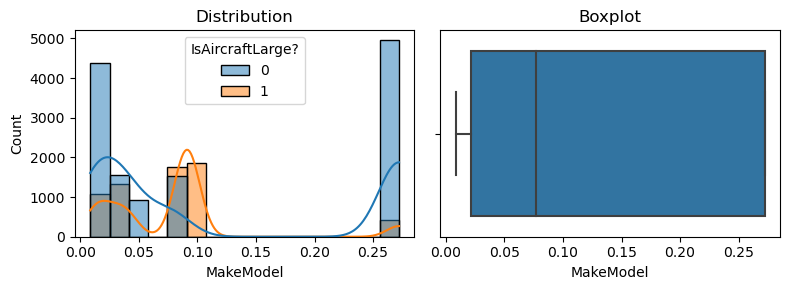

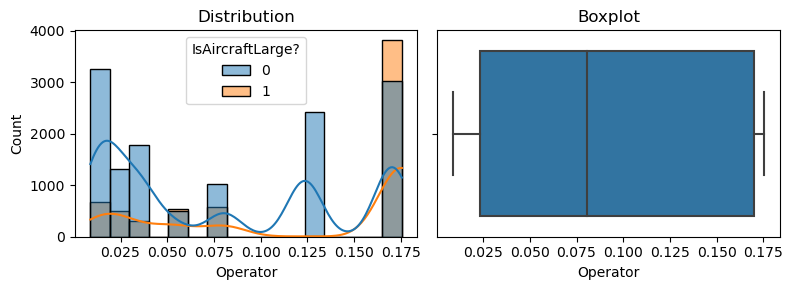

In [791]:
final_data = pd.concat([X_xgb_train, y_train], axis=1)

for col in X_xgb_train.columns:

    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    sns.histplot(
        final_data, x=col, hue='IsAircraftLarge?', 
        kde=True, ax=axes[0]
    )
    axes[0].set_title('Distribution')

    sns.boxplot(
        final_data, x=col, hue='IsAircraftLarge?', 
        flierprops={'marker':'o', 'markersize':2}, ax=axes[1]
    )
    axes[1].set_title('Boxplot')

    plt.tight_layout()
    plt.show()

# SUMMARY OF PREPROCESSING

### THE RAW DATA 

(1) Introduction to raw data with 25,429 observations, 25 features, and one binary target **`IsAircraftLarge?`** (Yes/No).

### PREPROCESSING THE DATA 

(2) Explored missing values.

(3) Dropped features **`RecordID`**, **`AircraftType`**, **`Remarks`**, **`FlightDate`**, **`Effect`**, and **`ConditionsPrecipitation`** due to obvious irrelevance to hypothesis of whether any of the features contribute to whether the aircraft that struck wildlife is large or not, or high percentage of missing values.

(4) Dropped duplicate rows, decreasing observations and dimensionality to 24,716 rows and 20 features.

(5) Confirmed current distribution of data types are 2 bool, 3 numerical, and 14 categorical features, and 1 binary target.

(6) Converted a few features into the correct data type, then imputed **`Engines`** and **`OriginState`** to maintain clarity, consistency, and easy extraction for encoding categorical features at a later stage.

(7) Confirm there are 5 numerical and 14 categorical after conversion.

(8) Mapped binary features **`Damage`**, **`RemainsCollected?`**, **`RemainsSentToSmithsonian`**, and **`PilotWarned`**, and ordinal features **`AltitudeBin`**, **`NumberStruck`**, **`WildlifeSize`**, and **`ConditionsSky`**. (Total of 8 features)

(8) Explored target **`IsAircraftLarge?`** proportions, and mapped to **`{'Yes':1, 'No':0}`**.

(9) Splitted data 80-10-10, where train has 19,772 observations, while validation and test have 2472 observations.

(10) Explored disproportional class distributions for nominal high-cardinality features **`AirportName`**, **`MakeModel`**, **`Operator`**, **`OriginState`**, **`FlightPhase`**, and **`WildlifeSpecies`**, and rare labelled and frequency encoded them.

(11) Checked for null values from frequency encoding, and removed **`RemainsCollected?`** and **`RemainsSentToSmithsonian`** since they both turned out 100% null.

### EMBEDDED FEATURE SELECTION 

(12) Used **`XGBoost`** embedded feature selection to narrow down dimensionality to two features **`Operator`** with 87.16%, and **`MakeModel`** with 12.84% importance.

(13) Confirmed the final train data shape has 19,772 and validation/test have 2,472 observations, both with 2 features.

(14) Visualized distributions and boxplot for **`MakeModel`** and **`Operator`**.

# TRAINING AND EVALUATING DIFFERENT ML MODELS

- XBGoost (re-fitted from feature selection)
- Random Forest
- Support Vector Machine (i.e., linear, poly, radial, sigmoid)
- K Nearest Neighbors (KNN)
- Gaussian Naive Bayes (GNB)
- Artificial Neural Networks (ANN)
- Recurrent Neural Networks (RNN)
  - LSTM
  - GRU
- Convolutional Neural Networks (CNN)

# Re-fit the `XGBoost` model 

In [792]:
def train_xgb_model(n_estimators, max_depth, learning_rate):
    xgb_model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        eval_metric = ["auc", "error"],
        random_state=1
    )

    xgb_model.fit(X_xgb_train, y_train, 
            eval_set = [(X_xgb_train, y_train), (X_xgb_test, y_test)],
            verbose=False)
    
    y_pred = xgb_model.predict(X_xgb_test)
    accuracy = round(accuracy_score(y_test, y_pred), 2)

    return xgb_model, y_pred, accuracy 

- Train on a smaller number of trees and depth since there are only two features left, but increase the learning rate since there is a lot less data to learn from now. Here, the model fit returns an 89% accuracy for 40 trees, 5 depths, and a 0.01 learning rate. Since 50 trees returns the same accuracy as 40, it's considered overfitting.

In [793]:
xgb_model1, y_pred1, accuracy1 = train_xgb_model(30, 5, 0.01)
xgb_model2, y_pred2, accuracy2 = train_xgb_model(40, 5, 0.01)
xgb_model3, y_pred3, accuracy3 = train_xgb_model(50, 5, 0.01)

print(f'xgb accuracy = {accuracy1}')
print(f'xgb accuracy = {accuracy2}')
print(f'xgb accuracy = {accuracy3}')

xgb accuracy = 0.86
xgb accuracy = 0.89
xgb accuracy = 0.89


### `XGBoost` feature importance plot

The feature importance plot for the last two features that carry the most weight.

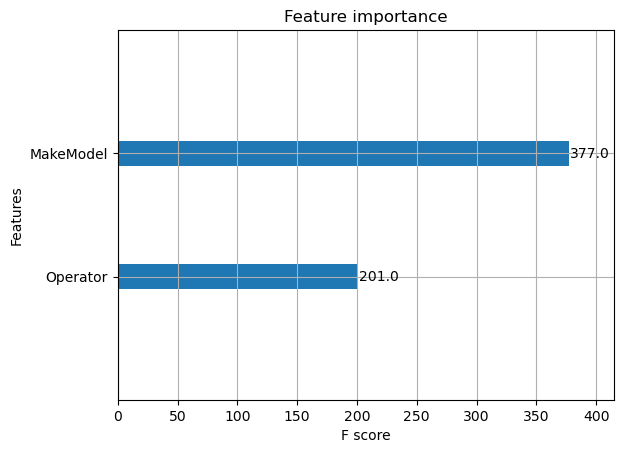

In [794]:
xgb.plot_importance(xgb_model2)
plt.show()

### `XGBoost` AUC curve, confusion matrix, and heatmap

- The AUC plot shows the train and test curves a very close pattern, meaning there is decent training and the hyperparameters are set to good values.
- The confusion matrix shows a near perfect prediction for non-large aircraft sizes, but is subpar for if  the aircraft is large. 
- The two remaining features **`Operator`** and **`MakeModel`** don't share any multicollinearity though, which is a positive sign that the feature selection did well.

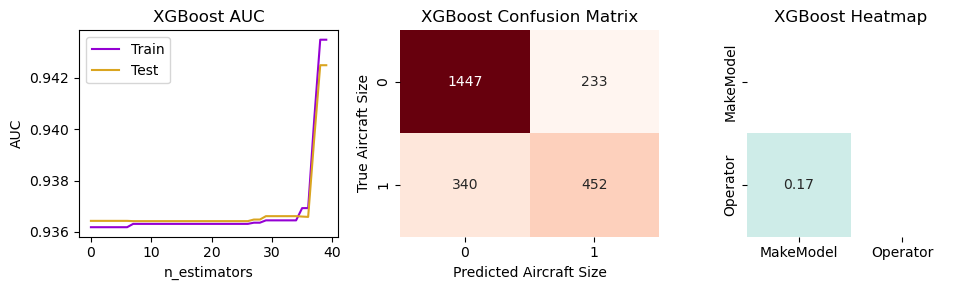

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1680
           1       0.66      0.57      0.61       792

    accuracy                           0.77      2472
   macro avg       0.73      0.72      0.72      2472
weighted avg       0.76      0.77      0.76      2472



In [795]:
cm = confusion_matrix(y_test, y_pred)

results = xgb_model2.evals_result()
n_estimators = len(results['validation_0']['error'])
xticks = range(0, 40)

fig, axes = plt.subplots(1,3, figsize=(10,3))
plt.subplot(1,3,1)

plt.plot(xticks, results['validation_0']['auc'], label='Train', color='darkviolet')
plt.plot(xticks, results['validation_1']['auc'], label='Test', color='goldenrod')
axes[0].set_ylabel('AUC')
axes[0].set_xlabel('n_estimators')
axes[0].set_title('XGBoost AUC')
plt.legend()

plt.subplot(1,3,2)
sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Reds', ax=axes[1])
axes[1].set_ylabel('True Aircraft Size')
axes[1].set_xlabel('Predicted Aircraft Size')
axes[1].set_title('XGBoost Confusion Matrix')

plt.subplot(1,3,3)
corr = X_xgb_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap = "BrBG", 
            cbar=False, square=True, vmin=-1, vmax=1, ax=axes[2])
axes[2].set_title('XGBoost Heatmap')

plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred))

# Random Forest

Since random forest is not as strong as **`XGBoost`**. the size of **`n_estimators`** and sometimes the **`max_depth`** is larger.

In [796]:
def train_rf_model(n_estimators, max_depth):
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth,
        random_state=1
    )
    
    rf_model.fit(X_xgb_train, y_train)
    
    y_pred = rf_model.predict(X_xgb_test)
    accuracy = round(accuracy_score(y_test, y_pred), 2)

    return y_pred, accuracy

In [797]:
y_pred1, accuracy1 = train_rf_model(100, 15)
y_pred2, accuracy2 = train_rf_model(200, 5)
y_pred3, accuracy3 = train_rf_model(100, 3)
y_pred4, accuracy4 = train_rf_model(300, 3)

for i, accuracy in enumerate([accuracy1, accuracy2, accuracy3, accuracy4]):
    print(f'rf model {i+1} accuracy: {accuracy}')

rf model 1 accuracy: 0.98
rf model 2 accuracy: 0.91
rf model 3 accuracy: 0.85
rf model 4 accuracy: 0.87


- The best random forest model had parameters **`n_estimators=100`** and **`max_depth=15`**. Here are four confusion matrices to compare all the models.
- Noticeably, all the models always predict non-large aircrafts with 100% accuracy, but are split between how well they predict large aircrafts.

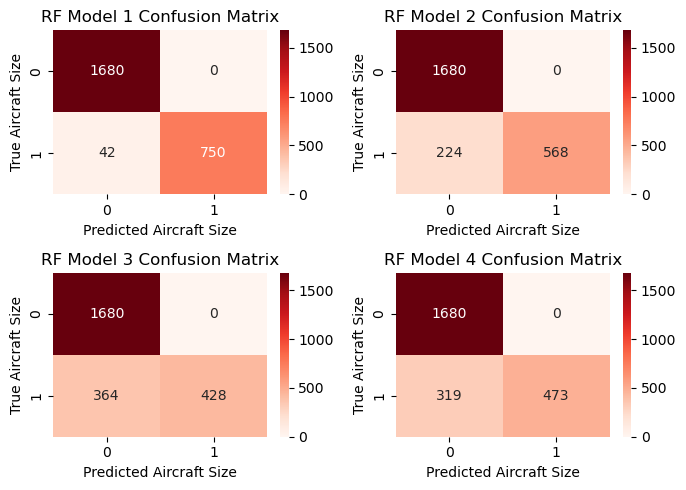

In [798]:
fig, axes = plt.subplots(2, 2, figsize=(7, 5))

for i, y_pred in enumerate([y_pred1, y_pred2, y_pred3, y_pred4]):
    
    cm = confusion_matrix(y_test, y_pred)
    ax = axes[i // 2, i % 2]
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cbar=True, cmap='Reds')
    ax.set_xlabel('Predicted Aircraft Size')
    ax.set_ylabel('True Aircraft Size')
    ax.set_title(f'RF Model {i+1} Confusion Matrix')

plt.tight_layout()
plt.show()

In [799]:
y_pred_list = [y_pred1, y_pred2, y_pred3, y_pred4]

for i, y_pred in enumerate(y_pred_list):
    print(f'RF Model {i+1} classification report')
    print(classification_report(y_test, y_pred))
    print('----------------------------------------------------------\n')

RF Model 1 classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1680
           1       1.00      0.95      0.97       792

    accuracy                           0.98      2472
   macro avg       0.99      0.97      0.98      2472
weighted avg       0.98      0.98      0.98      2472

----------------------------------------------------------

RF Model 2 classification report
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1680
           1       1.00      0.72      0.84       792

    accuracy                           0.91      2472
   macro avg       0.94      0.86      0.89      2472
weighted avg       0.92      0.91      0.90      2472

----------------------------------------------------------

RF Model 3 classification report
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1680
           1      

# Support Vector Machine

### Linear, poly, radial, and sigmoid

In [800]:
def train_svc_model(kernel):
    svc_model = SVC(kernel=kernel, random_state=1)
    
    svc_model.fit(X_xgb_train, y_train)
    y_pred = svc_model.predict(X_xgb_test)
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    
    return y_pred, accuracy

- The accuracies for these are much lower compared to previous models. Note that the poly and radial kernels perform better than the linear kernel, implying the data doesn't have a linear relationship. The linear kernel is also not appropriate since this is a small dataset of only two features. The extremely low accuracy from the sigmoid kernel denotes overfitting with this particular ML algorithm. It seems this data works best with either poly or radial kernels.

In [801]:
y_pred1, accuracy1 = train_svc_model('linear')
y_pred2, accuracy2 = train_svc_model('poly')
y_pred3, accuracy3 = train_svc_model('rbf')
y_pred4, accuracy4 = train_svc_model('sigmoid')

for (accuracy, kernel) in zip([accuracy1, accuracy2, accuracy3, accuracy4],
                              ['linear', 'poly', 'radial', 'sigmoid']):
    print(f'SVC {kernel} accuracy: {accuracy}')

SVC linear accuracy: 0.75
SVC poly accuracy: 0.83
SVC radial accuracy: 0.83
SVC sigmoid accuracy: 0.52


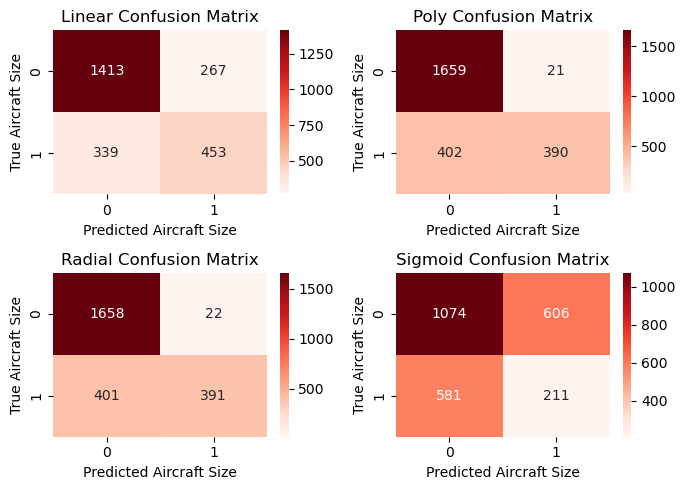

In [802]:
fig, axes = plt.subplots(2, 2, figsize=(7, 5))

for i, (y_pred, kernel) in enumerate(zip([y_pred1, y_pred2, y_pred3, y_pred4],
                                         ['Linear', 'Poly', 'Radial', 'Sigmoid'])):
    
    cm = confusion_matrix(y_test, y_pred)
    ax = axes[i // 2, i % 2]
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cbar=True, cmap='Reds')
    ax.set_xlabel('Predicted Aircraft Size')
    ax.set_ylabel('True Aircraft Size')
    ax.set_title(f'{kernel} Confusion Matrix')

plt.tight_layout()
plt.show()

# K Nearest Neighbors

In [803]:
def train_knn_model(n_neighbors):
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    knn_model.fit(X_xgb_train, y_train)
    y_pred = knn_model.predict(X_xgb_test)
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    
    return y_pred, accuracy

In [804]:
for i in range(1, 6):
    y_pred, accuracy = train_knn_model(i)
    print(f'knn model {i} accuracy = {accuracy}')

knn model 1 accuracy = 0.98
knn model 2 accuracy = 0.98
knn model 3 accuracy = 0.97
knn model 4 accuracy = 0.98
knn model 5 accuracy = 0.98


- All of these models perform surprisingly and return similar accuracies. However, there's suspicion it could be due to a small dataset of only two features, so there's not as many neighbors to consider. Here a couple confusion matrices to compare models 2 and 3, one with 98% and one with 97% accuracy.

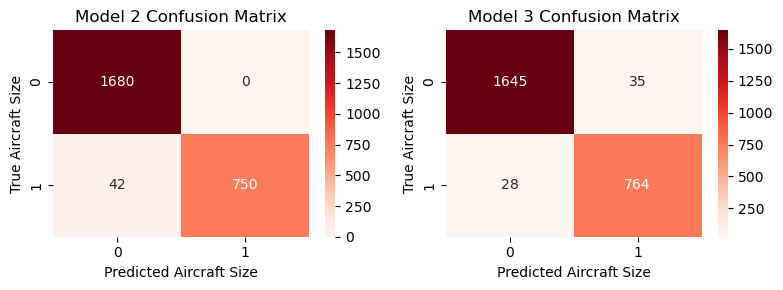

Model 2 classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1680
           1       1.00      0.95      0.97       792

    accuracy                           0.98      2472
   macro avg       0.99      0.97      0.98      2472
weighted avg       0.98      0.98      0.98      2472

----------------------------------------------------------

Model 3 classification report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1680
           1       0.96      0.96      0.96       792

    accuracy                           0.97      2472
   macro avg       0.97      0.97      0.97      2472
weighted avg       0.97      0.97      0.97      2472

----------------------------------------------------------



In [805]:
y_pred2, accuracy2 = train_knn_model(2)
y_pred3, accuracy3 = train_knn_model(3)

y_pred_list = [y_pred2, y_pred3]

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

for i, y_pred in enumerate(y_pred_list):
    
    cm = confusion_matrix(y_test, y_pred)
    ax = axes[i // 1]
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cbar=True, cmap='Reds')
    ax.set_xlabel('Predicted Aircraft Size')
    ax.set_ylabel('True Aircraft Size')
    ax.set_title(f'Model {i+2} Confusion Matrix')
    
plt.tight_layout()
plt.show()

for i, y_pred in enumerate(y_pred_list):
    print(f'Model {i+2} classification report')
    print(classification_report(y_test, y_pred))
    print('----------------------------------------------------------\n')

# Gaussian Naive Bayes

In [806]:
def train_gnb_model():
    gnb_model = GaussianNB()
    
    gnb_model.fit(X_xgb_train, y_train)
    y_pred = gnb_model.predict(X_xgb_test)
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    
    return y_pred, accuracy

- Testing only one Gaussian model here since there's no hyperparameter arguments to finetune. It does okay with a 77% accuracy, but not as well as some other models.

gnb model accuracy: 0.77


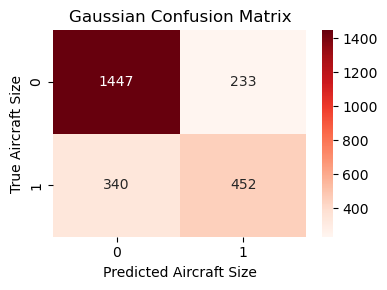

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1680
           1       0.66      0.57      0.61       792

    accuracy                           0.77      2472
   macro avg       0.73      0.72      0.72      2472
weighted avg       0.76      0.77      0.76      2472



In [807]:
y_pred, accuracy = train_gnb_model()
print(f'gnb model accuracy: {accuracy}')

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='g', cbar=True, cmap='Reds')
plt.xlabel('Predicted Aircraft Size')
plt.ylabel('True Aircraft Size')
plt.title(f'Gaussian Confusion Matrix')
plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred))

# FUNCTIONS TO FOR TRAINING AND EVALUATING NUERAL NETWORKS 

### Details on function descriptions and parameters:

(1) **`random_state`**: (This function uses tensforflow, numpy, and random seed to maintain reproducible results for the FNN.)
  - Default seed value of 100.
  
(2) **`compile_fit`**: (This function takes in tunable hyperparameters for compiling and fitting the FNN, and prints metrics.)
  - Number of epochs `epochs`
  - Batch size `batch_size`
  - Learning rate value `learning_rate`
  - Model architecture `nn` 
  
(3) **`visualize_nn_results`**: (This function visualizes the model's losses, accuracies, and confusion matrix.)
  - Model architecture `nn`
  - Output `nn_fit` from the function `compile_fit`
  - String name `nn_string_name` to denote type of neural network

In [808]:
def random_state(seed_value=100):
    
    tf.random.set_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)

In [809]:
def compile_fit(epochs, batch_size, learning_rate, nn):
    
    # select Adam optimizer and learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # compile model
    nn.compile(optimizer = optimizer, 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
    
    # fit model
    nn_fit = nn.fit(X_xgb_train, y_train, 
                      validation_data = (X_xgb_validation, y_validation), 
                      epochs = epochs, batch_size=batch_size, verbose=False)

    # evaluate model train accuracy
    train_loss, train_acc = nn.evaluate(X_xgb_train, y_train)
    print(f'Training loss: {train_loss}')
    print(f'Training accuracy: {train_acc}')
    
    # evaluate model test accuracy
    print('\n')
    test_loss, test_acc = nn.evaluate(X_xgb_test, y_test)
    print(f'Testing loss: {test_loss}')
    print(f'Testing accuracy: {test_acc}')
    
    return nn_fit

In [810]:
def visualize_nn_results(nn, nn_fit, nn_string_name):
    
    # visualize loss, accuracy, and confusion matrix
    fig, axes = plt.subplots(1,3, figsize=(10,3))


    plt.subplot(1,3,1)
    plt.plot(nn_fit.history['loss'], label='loss', color='palevioletred')
    plt.plot(nn_fit.history['val_loss'], label='val_loss', color='lightseagreen')
    axes[0].set_xlabel('epochs')
    axes[0].set_ylabel('loss')
    axes[0].set_title(f'{nn_string_name} Loss vs. Val_loss')
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(nn_fit.history['accuracy'], label='accuracy', color='mediumorchid')
    plt.plot(nn_fit.history['val_accuracy'], label='val_accuracy', color='orange')
    axes[1].set_xlabel('epochs')
    axes[1].set_ylabel('accuracy')
    axes[1].set_title(f'{nn_string_name} Accuracy vs. Val_accuracy')
    plt.legend()
    
    # confusion matrix
    y_pred = nn.predict(X_xgb_test).flatten()

    # (aircraft is large)=1 if probability of y_pred > 0.5, 
    # else (aircraft is not large)=0
    y_pred = np.where(y_pred > 0.5, 1, 0)

    plt.subplot(1,3,3)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axes[2])
    axes[2].set_xlabel('Predicted Aircraft Size')
    axes[2].set_ylabel('True Aircraft Size')
    axes[2].set_title(f'{nn_string_name} Confusion Matrix')
    
    plt.tight_layout()
    plt.show()

    print(classification_report(y_test, y_pred))

# TRAIN, COMPILE, FIT, EVALUATE, AND VISUALIZE 

In [811]:
N, D = X_xgb_train.shape

# Artificial neural networks

618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8418 - loss: 0.3899
Training loss: 0.38483545184135437
Training accuracy: 0.8463989496231079


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8420 - loss: 0.3983
Testing loss: 0.38384810090065
Testing accuracy: 0.8466828465461731
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


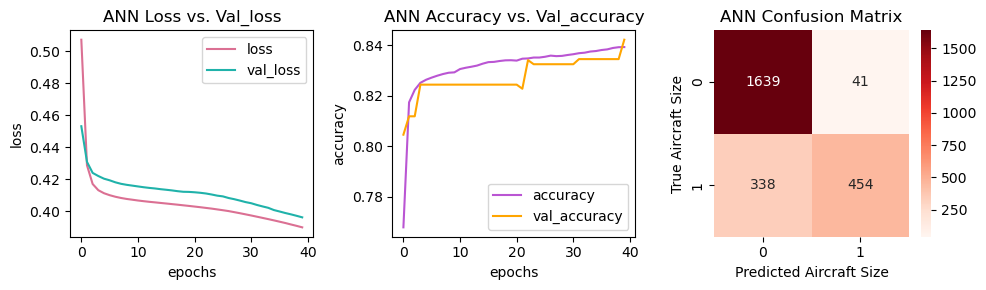

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1680
           1       0.92      0.57      0.71       792

    accuracy                           0.85      2472
   macro avg       0.87      0.77      0.80      2472
weighted avg       0.86      0.85      0.84      2472



In [812]:
random_state()

# build the model
ann = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (D,)),     
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

ann_fit = compile_fit(40, 15, 0.001, ann)

visualize_nn_results(ann, ann_fit, 'ANN')

618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8903 - loss: 0.2464
Training loss: 0.2406120002269745
Training accuracy: 0.8946489691734314


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.8881 - loss: 0.2530
Testing loss: 0.24418745934963226
Testing accuracy: 0.8923948407173157
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


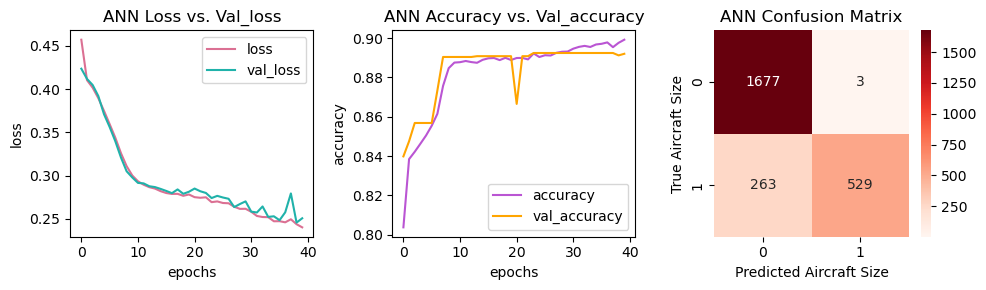

              precision    recall  f1-score   support

           0       0.86      1.00      0.93      1680
           1       0.99      0.67      0.80       792

    accuracy                           0.89      2472
   macro avg       0.93      0.83      0.86      2472
weighted avg       0.91      0.89      0.89      2472



In [813]:
random_state()

# build the model
ann = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (D,)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

ann_fit = compile_fit(40, 15, 0.001, ann)

visualize_nn_results(ann, ann_fit, 'ANN')

618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step - accuracy: 0.9061 - loss: 0.2348
Training loss: 0.22928382456302643
Training accuracy: 0.9101759791374207


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9066 - loss: 0.2458
Testing loss: 0.23841141164302826
Testing accuracy: 0.905339777469635
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


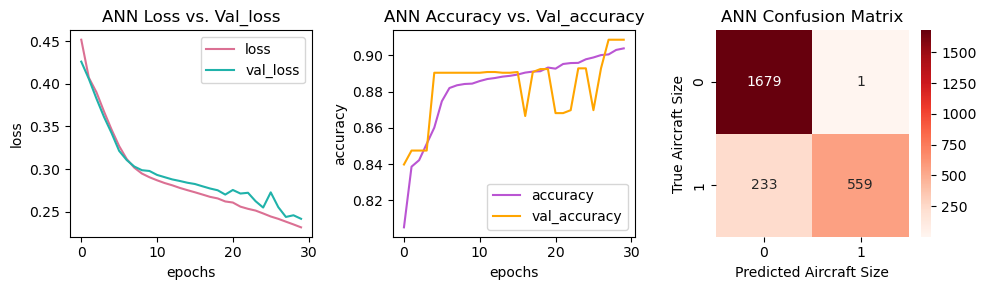

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1680
           1       1.00      0.71      0.83       792

    accuracy                           0.91      2472
   macro avg       0.94      0.85      0.88      2472
weighted avg       0.92      0.91      0.90      2472



In [814]:
random_state()

# build the model
ann = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (D,)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

ann_fit = compile_fit(30, 10, 0.001, ann)

visualize_nn_results(ann, ann_fit, 'ANN')

### ANN performance analysis

The process to finetune the model included adding hiddent layers, changing the number of neurons per layer, and the hyperparameter arguments within the **`compile_fit()`** function (i.e., **`epochs`**, **`batch_size`**, **`learning_rate`**, and the model architecture itself, **`nn`**).

The best results are from the following model architecture and hyperparameter arguments:

**Model architecture named** **`ann`**:
- Input layer with two neurons for **`Operator`** and **`MakeModel`**.
- 3 hidden layers with chronologically decreasing number of neurons 128, 64, and 16, which all use **`activation=relu`**.
- Output layer with one neuron and **`activation=sigmoid`** for binary classification.

**Hyperparameters**:
- **`epochs=30`**
- **`batch_size=10`**
- **`learning_rate=0.001`**
- **`nn=ann`**

# Recurrent neural networks

### LSTM

618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9082 - loss: 0.2088
Training loss: 0.20071232318878174
Training accuracy: 0.9125025272369385


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9102 - loss: 0.2037
Testing loss: 0.2028372585773468
Testing accuracy: 0.909385085105896
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


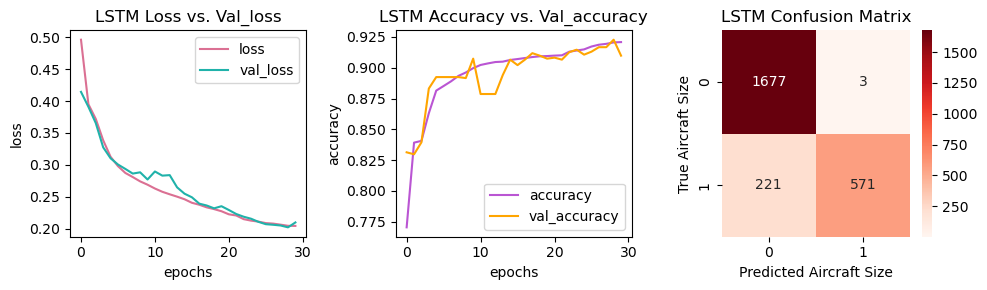

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1680
           1       0.99      0.72      0.84       792

    accuracy                           0.91      2472
   macro avg       0.94      0.86      0.89      2472
weighted avg       0.92      0.91      0.90      2472



In [818]:
random_state()

# build the model 
lstm = tf.keras.models.Sequential([ 
    tf.keras.layers.LSTM(64, input_shape=(X_xgb_train.shape[1], 1)),  
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_fit = compile_fit(30, 10, 0.001, lstm)

visualize_nn_results(lstm, lstm_fit, 'LSTM')

### LSTM performance analysis

The same hyperparameters from the best ANN model were used to compile and fit the LSTM model. Here, **`epochs=30`**, **`batch_size=10`**, and **`learning_rate=0.001`** are also used; however, the model architecture differs slightly. Though there are still 3 hidden layers with decreasing number of neurons, the number of neurons changed from 128, 64, and 16 in the ANN model to 64, 32, and 16 in the LSTM model. The accuracies for both neural networks, despite the slightly different number of neurons, is approximately the same at 90% or s0.

### GRU

618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9047 - loss: 0.2124
Training loss: 0.20652766525745392
Training accuracy: 0.9072931408882141


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9021 - loss: 0.2196
Testing loss: 0.21190756559371948
Testing accuracy: 0.9045307636260986
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


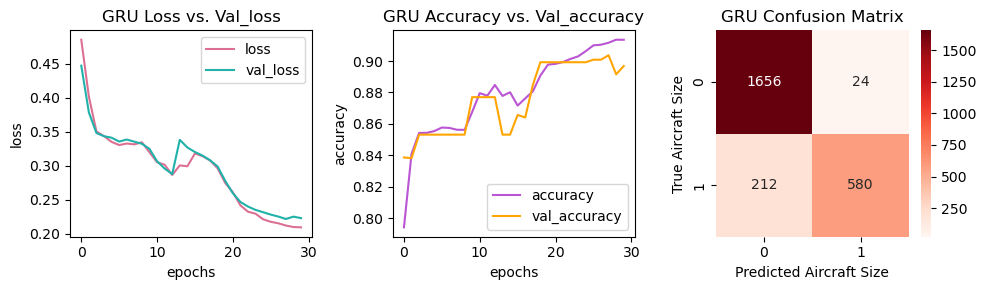

              precision    recall  f1-score   support

           0       0.89      0.99      0.93      1680
           1       0.96      0.73      0.83       792

    accuracy                           0.90      2472
   macro avg       0.92      0.86      0.88      2472
weighted avg       0.91      0.90      0.90      2472



In [817]:
random_state()

gru = tf.keras.models.Sequential([ 
    tf.keras.layers.GRU(64, input_shape=(X_xgb_train.shape[1], 1)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

gru_fit = compile_fit(30, 10, 0.005, gru)

visualize_nn_results(gru, gru_fit, 'GRU')

### GRU performance analysis

The accuracies fo both train and test at about 90% and losses are maintained despite only one input layer of 64 neurons, and slightly higher **`learning_rate=0.005`**. The epochs and batch size were kept at **`epochs=30`** and **`batch_size=10`**.

# Convolutional neural networks

618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8236 - loss: 0.4216
Training loss: 0.4147927463054657
Training accuracy: 0.8265223503112793


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8250 - loss: 0.4245
Testing loss: 0.4154704213142395
Testing accuracy: 0.8305016160011292
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


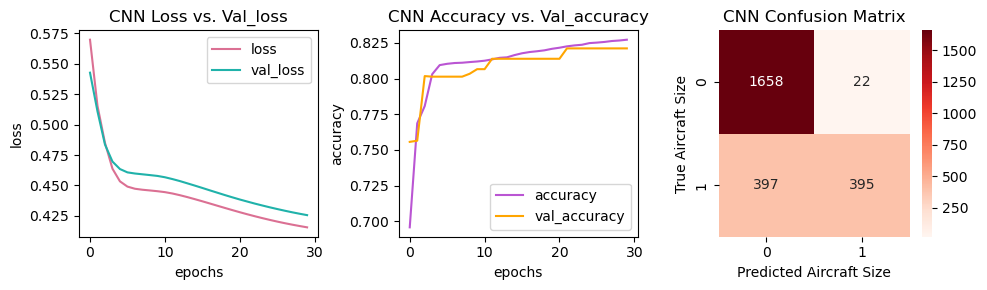

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1680
           1       0.95      0.50      0.65       792

    accuracy                           0.83      2472
   macro avg       0.88      0.74      0.77      2472
weighted avg       0.85      0.83      0.81      2472



In [820]:
random_state()

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 2, activation='relu', input_shape=(X_xgb_train.shape[1], 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_fit = compile_fit(30, 10, 0.001, cnn)

visualize_nn_results(cnn, cnn_fit, 'CNN')

618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8277 - loss: 0.4118
Training loss: 0.40762758255004883
Training accuracy: 0.831782341003418


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8266 - loss: 0.4180
Testing loss: 0.40357813239097595
Testing accuracy: 0.8309061527252197
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


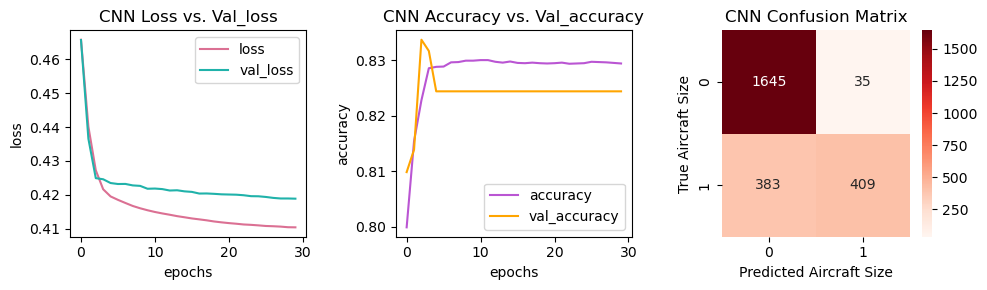

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1680
           1       0.92      0.52      0.66       792

    accuracy                           0.83      2472
   macro avg       0.87      0.75      0.77      2472
weighted avg       0.85      0.83      0.82      2472



In [823]:
random_state()

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 2, activation='relu', input_shape=(X_xgb_train.shape[1], 1)),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_fit = compile_fit(30, 10, 0.005, cnn)

visualize_nn_results(cnn, cnn_fit, 'CNN')

### CNN performance analysis

Two different CNN model architectures were trained and evaluated. The first had the same **`epochs=30`**, **`batch_size=10`**, and **`learning_rate=0.001`** as the best ANN model, with one convolutional layer of 64 neurons and one flatten layer. The second had the same **`epochs=30`**, **`batch_size=10`**, and **`learning_rate=0.005`** as the best GRU model, and nearly the model as the first CNN. However, an extra dense layer of 16 neurons is added.

Both CNN models performed fairly similiar without risk of overfitting, but the second model with **`learning_rate=0.005`** did a little better.

# Comparison between all ML algorithms

The best performing algorithms are the random forest and the k nearest neighbor models. 

- The random forest achieved a 98% accuracy with **`n_estimators=100`** and **`max_depth=15`**. 
- The KNN algorithm also achieved 98% accuracy for nearly all number of neighbors ranged from 1 to 5, except for **`k=4`** neighbors, which achieved only a slighly lower accuracy of 97%.

# Comparison between all neural networks

Overall, the LSTM model did the best with the following structure and hyperparameters:

**Model architecture named** **`ann`**:
- Input layer with two neurons for **`Operator`** and **`MakeModel`**.
- 3 hidden layers with chronologically decreasing number of neurons 64, 32, and 16, which all use **`activation=relu`**.
- Output layer with one neuron and **`activation=sigmoid`** for binary classification.

**Hyperparameters**:
- **`epochs=30`**
- **`batch_size=10`**
- **`learning_rate=0.001`**
- **`nn=lstm`**

The accuracies for train and test are 91.25% and 90.94% respectively. Both have a loss of about 20%, which could definitely be trained some more to be lower.